In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle as pkl
from lib.utils import *
from copy import deepcopy as dcp
from os import walk
import shutil
import seaborn as sb
import pandas as pd
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'

### Load the data

In [2]:
combined_data_path = "../Data/"
results_log_init = get_log(combined_data_path, 'HH_with_init')
init_res = torch.sqrt(results_log_init['results'])
init_runtime = results_log_init['runtime']
results_log_noinit = get_log(combined_data_path, 'HH_no_init')
noinit_res = torch.sqrt(results_log_noinit['results'])
noinit_runtime = results_log_noinit['runtime']

## Results with initialization step

### Compute the values of interest for the error
Looking at:
- The "zeroed results" which refers to the improvement from the initial solution $\theta_{init}^T \, , \; T \in \text{Set of 20 targets}$
- The mean, standard deviation, min and max values of the error at the last iteration

In [3]:
loss_fn = 'RMSE'
combined_zeroed_res = torch.zeros(8,20,50,101)
combined_CI = []
for i in range(len(init_res)):
    for ii in range(8):
        combined_zeroed_res[ii][:,25*i:25*(i+1),:] = init_res[i,ii] - init_res[i,ii,:,:,0:1].mean(1,keepdims = True)
combined_mean_res = combined_zeroed_res.mean(1).mean(1).squeeze()
combined_std_res = combined_zeroed_res.reshape((8,-1,101))[:,:,-1].std(1).squeeze()
combined_max_res = combined_zeroed_res.amax(2).mean(1).squeeze().unsqueeze(0) [:,:,-1] - combined_mean_res[:,-1].unsqueeze(0)
combined_min_res = combined_mean_res[:,-1].unsqueeze(0) - combined_zeroed_res.amin(2).mean(1).squeeze().unsqueeze(0) [:,:,-1]
min_max = torch.cat([combined_min_res,combined_max_res], dim = 0) 
print(combined_mean_res[:,-1])

### Compute the relative difference with baseline RS

In [29]:
combined_std_diff_res = combined_zeroed_res.reshape((8,-1,101))[:,-1].std(0).squeeze()
difference_from_bl = [[0] for _ in range(8)]
difference_std_from_bl = [0 for _ in range(8)]
for dfit, bas in [[0,0],[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0]]:
    difference_from_bl[dfit] = ((combined_zeroed_res[dfit][:,:,-1] - combined_zeroed_res[bas][:,:,-1].mean(1, keepdim=True))/combined_zeroed_res[bas][:,:,-1].mean()).view(-1) * 100  
    difference_std_from_bl[dfit] = (combined_zeroed_res[dfit][:,:,-1] - combined_zeroed_res[bas][:,:,-1].mean(1, keepdim=True)).std(1).mean()
print([round(difference_from_bl[i].mean().item(),3) for i in range(8)])

[0.0, 4.643, -0.809, 53.654, 14.193, 13.467, 17.208, 21.817]


### Define parameters of plots

In [13]:
initial_samp = [10000, 10000]
num_rounds = 100
samples = [initial_samp[0] + ii*25 for ii in range(num_rounds+1)]
show_CI = True
with_ylim = True
alp = 0.15
ncol = 2
labels_full = [
    'Random search',
    'Simulated annealing',
    'Particle swarm optimization',
    'CMA-ES',
    'Random search + AE',
    'Random search + PCA',
    'Simulated annealing + AE',
    'Simulated annealing + PCA'
]

### Constructing the pandas dataframe to use seaborn for violin plots

In [14]:
labels = ['SA','PSO','CMA-ES','RS + AE', 'RS + PCA', 'SA + AE', 'SA + PCA']
data_list = []
for i in range(1,8):
    alg_data = combined_zeroed_res[:,:,:,-1].view(8,-1).numpy()[i].tolist()
    for j in range(1000):
        data_list.append([alg_data[j],labels[i-1],"rest"])
for k in range(7):
    alg_data = combined_zeroed_res[:,:,:,-1].view(8,-1).numpy()[0].tolist()
    for j in range(1000):
        data_list.append([alg_data[j],labels[k],"RS"])
violin_plot_data_original_values = pd.DataFrame(data = data_list, columns=["RMSE","Metaheuristic","group"])
data_list = []
for i in range(1,8):
    alg_data = difference_from_bl[i].tolist()
    for j in range(1000):
        data_list.append([alg_data[j],labels[i-1],"rest"])
for k in range(7):
    alg_data = difference_from_bl[0].tolist()
    for j in range(1000):
        data_list.append([alg_data[j],labels[k],"RS"])
violin_plot_data_relative_values = pd.DataFrame(data = data_list, columns=["% decrease of RMSE","Metaheuristic","group"])

### Plot results

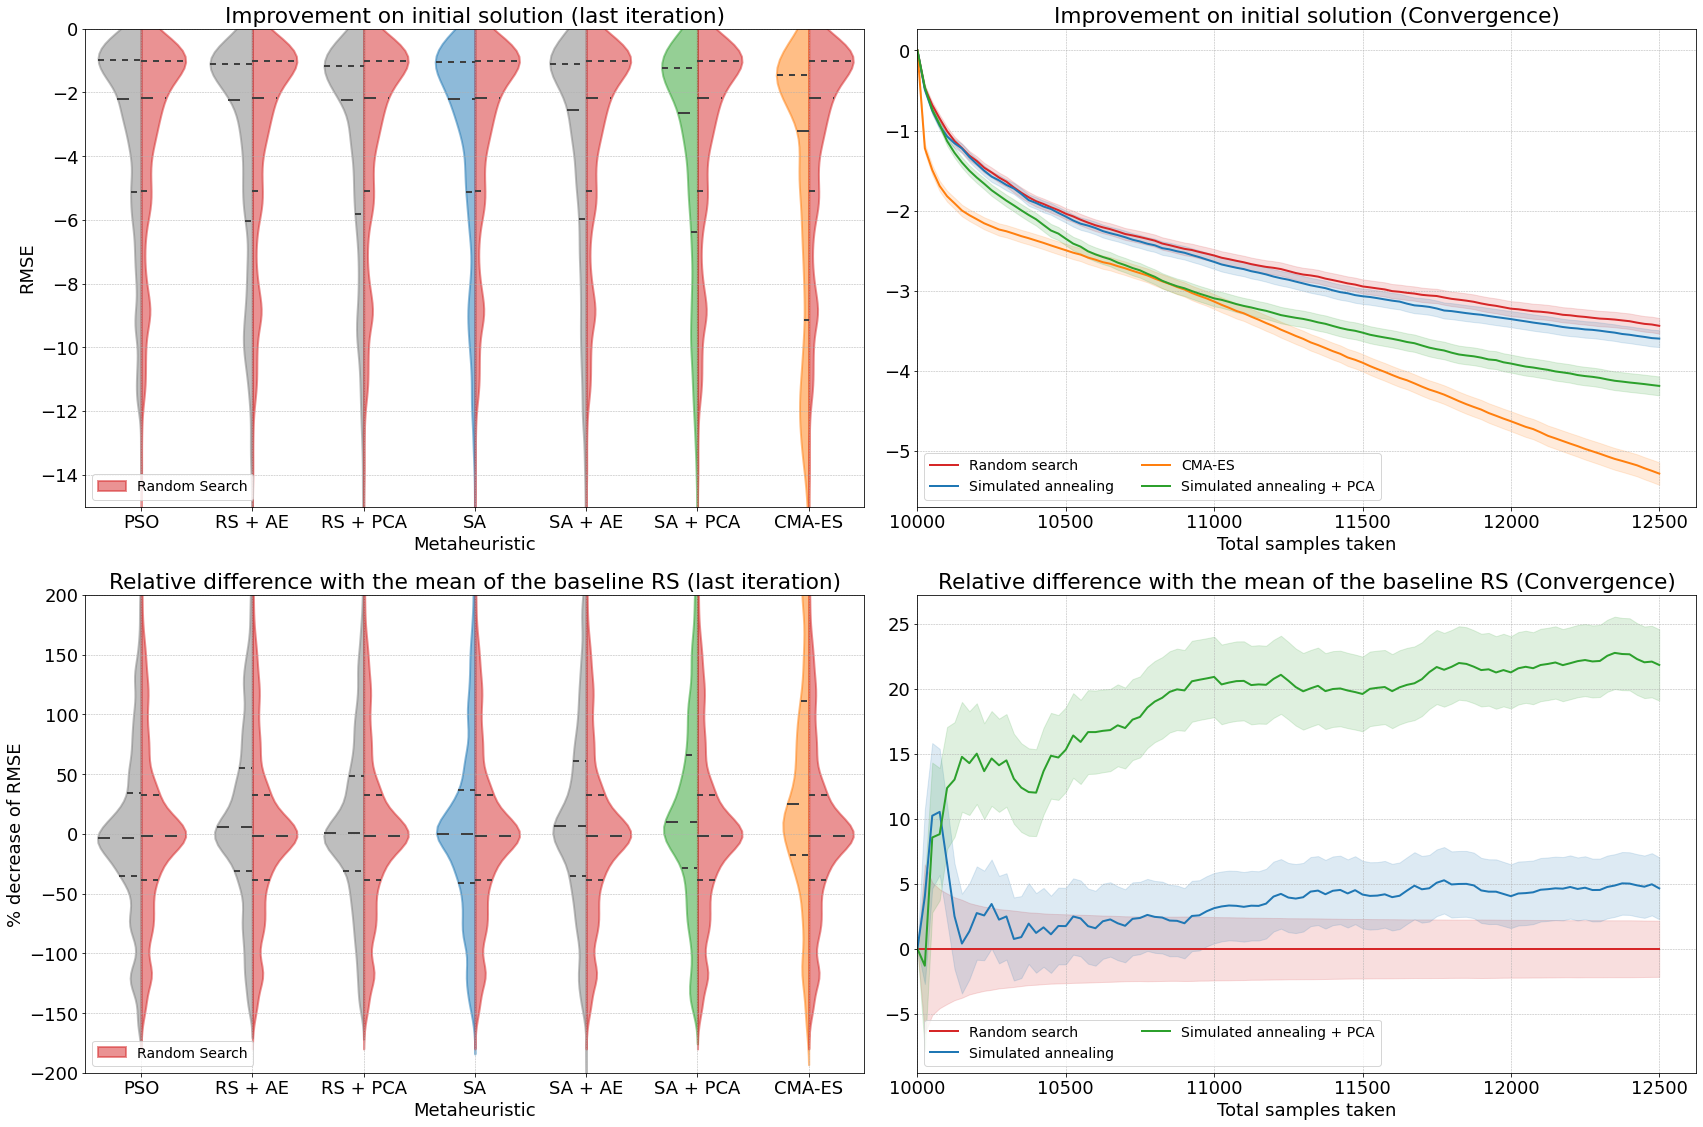

In [15]:
f = plt.figure(figsize=(24, 16))
colors = ['-C3','-C0','-C7', '-C1','-C7','-C7','-C7','-C2']

# First subplot (Last iteration for improvement)
ax = plt.subplot(2,2,1)
labels = ['RS','SA','PSO','CMA-ES','RS + AE', 'RS + PCA', 'SA + AE', 'SA + PCA']
vp_colors = [
    "tab:red",
    "tab:blue",
    "tab:gray",
    "tab:orange",
    "tab:gray",
    "tab:gray",
    "tab:gray",
    "tab:green",
]
order=[2,4,5,1,6,7,3]
plot_order = [labels[i] for i in order]
ordered_colors = []
for i in order:
    ordered_colors.append(vp_colors[i])
    ordered_colors.append("tab:red")
violin_parts = sb.violinplot(
    y = "RMSE",
    x = "Metaheuristic",
    hue = "group",
    data = violin_plot_data_original_values,
    split=True,
    order = plot_order,
    inner = "quartile",
    bw = 0.15,
)
counter = 0
to_legend = []
for c in violin_parts.get_children():
    if isinstance(c, mpl.collections.PolyCollection):
        c.set_color(f"{ordered_colors[counter]}")
        c.set_alpha(0.5)
        if counter ==1:
            to_legend.append(c)
        counter+=1
plt.legend(handles = to_legend, labels = ["Random Search"],prop = {'size':14}, loc = "lower left")
plt.grid(linestyle = "--", linewidth = 0.5)
if with_ylim:
    plt.ylim([-15,0])
plt.title(f'Improvement on initial solution (last iteration)')

# Second subplot (Convergence of improvement)
ax = plt.subplot(2,2,2)
for ii in [0,1,3,7]:
    plt.plot(samples, combined_mean_res[ii].numpy(), colors[ii], label = f"{labels_full[ii]}")
    if show_CI:
        CI  = [combined_mean_res[ii] - 0.03*combined_zeroed_res[ii].reshape((-1,101)).std(0), combined_mean_res[ii] + 0.03*combined_zeroed_res[ii].reshape((-1,101)).std(0)]
        plt.fill_between(samples,CI[0], CI[1], alpha = alp, color = colors[ii][1:])
plt.xlim([initial_samp[0], None])
plt.title(f'Improvement on initial solution (Convergence)')
plt.xlabel("Total samples taken")
plt.legend(ncol = 2, prop = {'size':14}, loc = 'lower left')
plt.grid(linestyle = "--", linewidth = 0.5)

# Third subplot (Last iteration for relative difference)
ax = plt.subplot(2,2,3)
violin_parts = sb.violinplot(
    y = "% decrease of RMSE",
    x = "Metaheuristic",
    hue = "group",
    data = violin_plot_data_relative_values,
    split=True,
    order = plot_order,
    inner = "quartile",
    bw = 0.15,
)
counter = 0
to_legend = []
for c in violin_parts.get_children():
    if isinstance(c, mpl.collections.PolyCollection):
        c.set_color(f"{ordered_colors[counter]}")
        c.set_alpha(0.5)
        if counter ==1:
            to_legend.append(c)
        counter+=1
plt.legend(handles = to_legend, labels = ["Random Search"],prop = {'size':14}, loc = "lower left")
plt.grid(linestyle = "--", linewidth = 0.5)
if with_ylim:
    plt.ylim([-200,200])
plt.title(f'Relative difference with the mean of the baseline RS (last iteration)')

# Fourth subplot (Convergence of relative difference)
ax = plt.subplot(2,2,4)
for dfit, bas in [[0,0],[1,0],[7,0]]:
    norm_conv = (combined_zeroed_res[dfit]-combined_zeroed_res[bas].mean(1, keepdim=True))/combined_zeroed_res[0].mean(0, keepdim=True).mean(1, keepdim=True) * 100
    norm_conv[:,:,0] *= 0
    plt.plot(samples,
     (norm_conv).mean(0).mean(0).numpy(),
      colors[dfit],
      label = f"{labels_full[dfit]}")
    if show_CI:
        CI  = [
                (norm_conv.mean(0).mean(0)) - 0.03*(norm_conv).reshape((-1,101)).std(0),
                (norm_conv.mean(0).mean(0)) + 0.03*(norm_conv).reshape((-1,101)).std(0)
              ]
        plt.fill_between(samples,CI[0], CI[1], alpha = alp, color = colors[dfit][1:])
plt.xlim([initial_samp[0], None])
plt.title(f'Relative difference with the mean of the baseline RS (Convergence)')
plt.xlabel("Total samples taken")
plt.legend(ncol = 2, prop = {'size':14}, loc = 'lower left')
plt.grid(linestyle = "--", linewidth = 0.5)

plt.tight_layout()
plt.show()

### Run time results

[35.9, 34.05, 23.37, 388.07, 59.75, 47.91, 65.31, 51.44]
[23.84, 12.0, 31.26, 17.4]
[0.66, 0.33, 0.92, 0.51]
21.125
0.6050000190734863


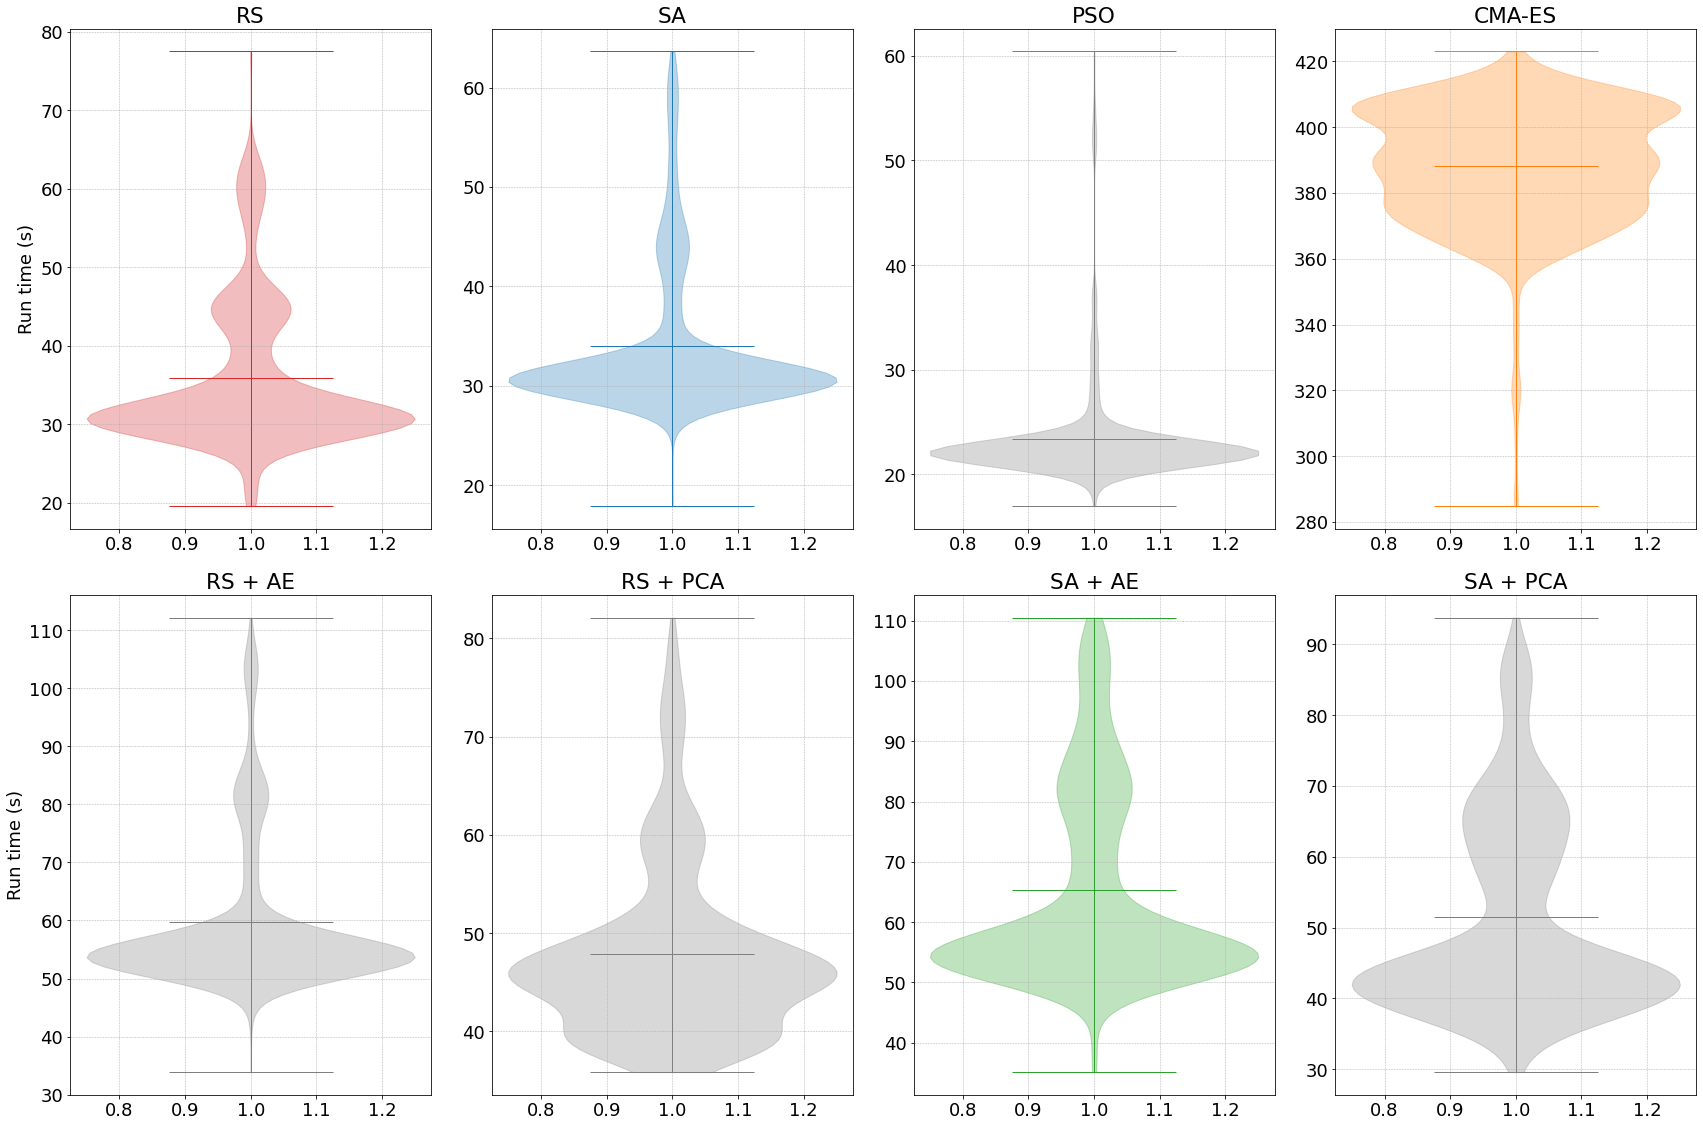

In [23]:

rt = init_runtime.view(2,8,-1)
rt = torch.transpose(rt,0,1)
rt = rt.reshape(8,-1)
f = plt.figure(figsize=(24, 16))
col = ['C3','C0','C7', 'C1','C7','C7','C2','C7']
labels = ['RS','SA','PSO','CMA-ES','RS + AE', 'RS + PCA', 'SA + AE', 'SA + PCA']
print([round(rt[i].mean().item(),2) for i in range(8)])
print([round((rt[i].mean().item() - rt[j].mean().item()),2) for i, j in [[4,0],[5,0],[6,1],[7,1]]])
print([round((rt[i].mean().item() - rt[j].mean().item())/rt[j].mean().item(),2) for i, j in [[4,0],[5,0],[6,1],[7,1]]])
print((23.84 + 12.0 + 31.26 + 17.4)/4)
print(torch.tensor([0.66, 0.33, 0.92, 0.51]).mean().item())
for i in range(8):
    ax = plt.subplot(2,4,1+i)
    violin_parts = ax.violinplot(
        rt[i].numpy(),
        showmeans=True,
    )
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        violin_parts[partname].set_edgecolor(col[i])
        violin_parts[partname].set_linewidth(1)

    for _, vp in enumerate(violin_parts["bodies"]):
        vp.set_color(col[i])
        vp.set_facecolor(col[i])
        vp.set_edgecolor(col[i])
    plt.grid(linestyle = "--", linewidth = 0.5)
    plt.title(f'{labels[i]}')
    if i%4==0:
        plt.ylabel(f"Run time (s)")
plt.tight_layout()
plt.show()

## Results without initialization step (from mid)

### Plot convergence results

30.213
33.5275


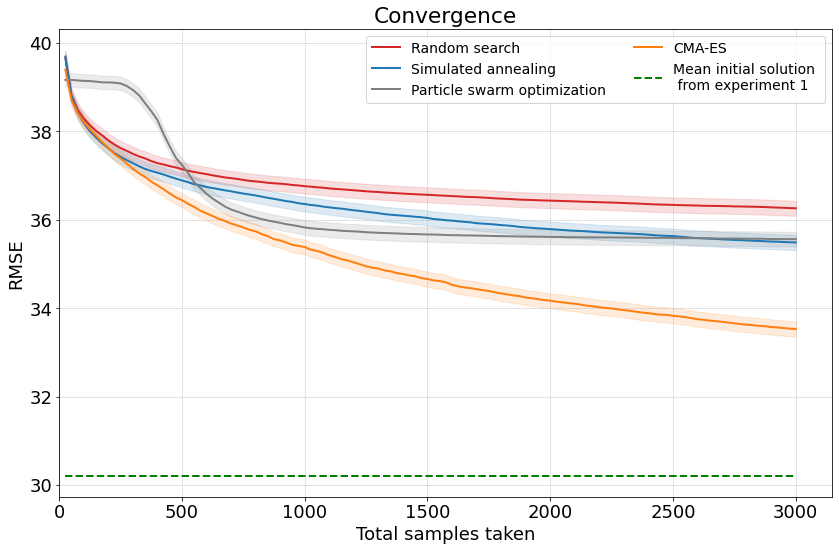

In [22]:
titles = ['No initialization']
loss_fn = 'RMSE'
initial_samp = [0]
num_rounds = 120
hide_pure = True
lim = num_rounds+1
show_std = True
ncol = 1
f = plt.figure(figsize=(12, 8))
labels_full = ['Random search','Simulated annealing','Particle swarm optimization','CMA-ES']
colors = ['C3','C0','C7','C1']
samples = [ii*25 for ii in range(1,121)]
ax = plt.subplot(1,1,1)
for ii in [0,1,2,3]:
    mean_results = noinit_res[ii].reshape((-1,121)).mean(0)
    plt.plot(samples, mean_results[1:].numpy(), colors[ii], label = f"{labels_full[ii]}")
    if show_CI:
        CI  = [mean_results[1:] - 0.03*noinit_res[ii].reshape((-1,121))[:, 1:].std(0), mean_results[1:] + 0.03*noinit_res[ii].reshape((-1,121))[:, 1:].std(0)]
        plt.fill_between(samples,CI[0], CI[1], alpha = alp, color = colors[ii])#, hatch = f'{hatches[ii%2]}')
plt.plot(samples,[init_res[:,0,:,0,0].mean() for _ in range(120)], "--g", label = "Mean initial solution \n from experiment 1")
print(round(init_res[:,0,:,0,0].mean().item(),4))
print(round(noinit_res[3].reshape((-1,121)).mean(0)[-1].item(),4))
plt.xlim([initial_samp[0], None])
plt.title(f'Convergence')
plt.xlabel("Total samples taken")
plt.ylabel(f"{loss_fn}")
plt.legend(ncol = 2, prop = {'size':14}, loc = 'upper right')
plt.grid(linestyle = "--", linewidth = 0.5)

plt.tight_layout()
plt.show()

### Run time 

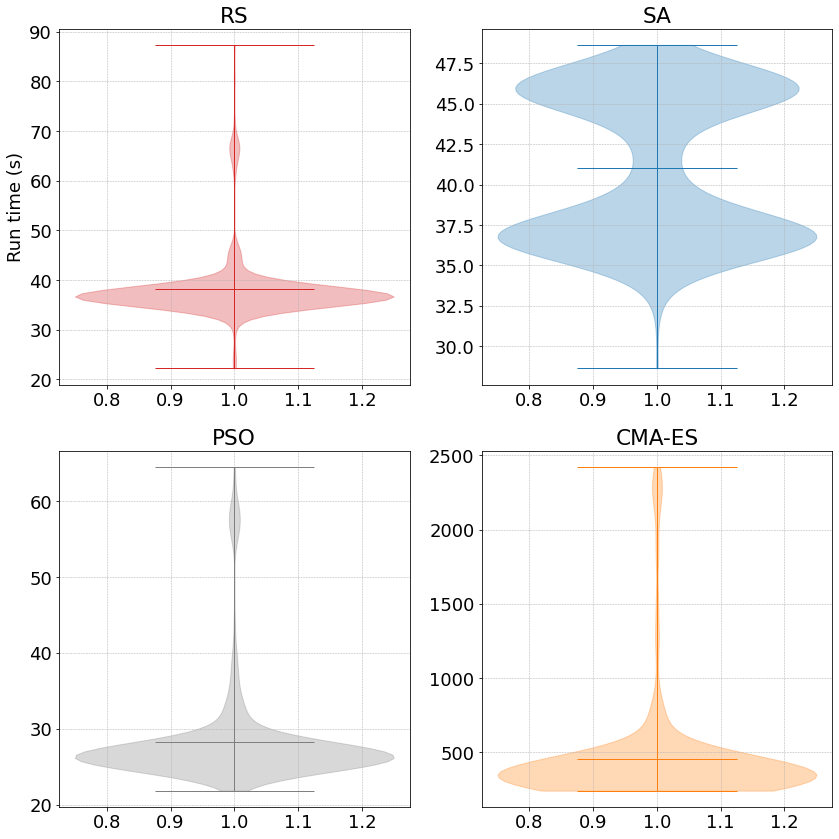

In [24]:
rt = noinit_runtime.view(4,-1)
f = plt.figure(figsize=(12, 12))
col = ['C3','C0','C7', 'C1','C7','C7','C2','C7']
labels = ['RS','SA','PSO','CMA-ES','RS + AE', 'RS + PCA', 'SA + AE', 'SA + PCA']
for i in range(4):
    ax = plt.subplot(2,2,1+i)

    violin_parts = plt.violinplot(
        rt[i].numpy(),
        showmeans=True,
    )
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = violin_parts[partname]
        vp.set_edgecolor(col[i])
        vp.set_linewidth(1)

    for _, vp in enumerate(violin_parts["bodies"]):
        vp.set_color(col[i])
        vp.set_facecolor(col[i])
        vp.set_edgecolor(col[i])

    plt.grid(linestyle = "--", linewidth = 0.5)
    plt.title(f'{labels[i]}')
    if i%4==0:
        plt.ylabel(f"Run time (s)")
plt.tight_layout()
plt.show()